# Setup

## Imports

In [1502]:
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import pycountry_convert as pc
import matplotlib.pyplot as plt

## Configuration

In [1503]:
pd.options.mode.chained_assignment = None

## Variables

In [1504]:
# Downloaded from https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries
salaries = pd.read_csv("ds_salaries.csv", index_col=0)


## Helpers

In [1505]:
def displayAsDF(ndarray, **kwargs):
  display(pd.DataFrame(ndarray, **kwargs))

# Prevent default print
pdp = display

vcs = lambda ndarray, ascending=True: ndarray.value_counts().sort_index(ascending=ascending)

displayVcs = lambda ndarray: displayAsDF(vcs(ndarray))
displayCols = lambda df: displayAsDF(df.columns, columns=["col"])

def pie_kwargs(col):
  x = vcs(col, False)
  return { "x": x, "labels": x.index, "autopct": "%1.1f%%" }

def white_fig(**kwargs):
  return plt.figure(facecolor="white", **kwargs)

# Adapted from https://stackoverflow.com/a/41385215
def pie_maker(total, cols):
  rows = (total // cols) + (total % cols)
  fig = white_fig(figsize=(5*cols, 4*rows))
  i = 1
  def pie(col):
    nonlocal i
    ax = fig.add_subplot(rows, cols, i)
    ax.pie(**pie_kwargs(col))
    plt.title(col.name)
    i += 1
  return pie

# Pre-processing

## Preview

In [1506]:
salaries

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


## Transformation

### Integer-ize `experience_level`

In [1507]:
salaries["experience_level"].replace({ "EN": 1, "MI": 2, "SE": 3, "EX": 4 }, inplace=True)

displayVcs(salaries["experience_level"])

,experience_level
1,88
2,213
3,280
4,26


### Integer-ize `company_size`

In [1508]:
salaries["company_size"].replace({ "S": 1, "M": 2, "L": 3 }, inplace=True)

displayVcs(salaries["company_size"])

,company_size
1,83
2,326
3,198


### Standard-scale Ordinal cols (`experience_level` & `company_size`)

Gives them meaning, based on mean & standard deviation

In [1509]:
ordinal_cols = ["experience_level", "company_size"]

standard_scaler = StandardScaler(with_mean=False)
salaries[ordinal_cols] = standard_scaler.fit_transform(salaries[ordinal_cols])

salaries[ordinal_cols].apply(displayVcs)
pdp()

,experience_level
1.274108,88
2.548217,213
3.822325,280
5.096434,26


,company_size
1.530264,83
3.060528,326
4.590792,198


### 0-Max Normalize Numeric cols except `salary_in_usd` & `work_year`

In [1510]:
numeric_cols = ordinal_cols + ["remote_ratio"]
salaries[numeric_cols] = salaries[numeric_cols].apply(lambda series: series/series.max())

salaries[numeric_cols].describe()

,experience_level,company_size,remote_ratio
count,607.000000,607.000000,607.000000
mean,0.600494,0.729819,0.709226
std,0.196377,0.218007,0.407091
min,0.250000,0.333333,0.000000
25%,0.500000,0.666667,0.500000
50%,0.750000,0.666667,1.000000
75%,0.750000,1.000000,1.000000
max,1.000000,1.000000,1.000000


### Booleanize `employee_residence` as `ricl`

***Resides In `company_location`**: whether residence is in same country as company*

In [1511]:
salaries["ricl"] = salaries["company_location"] == salaries["employee_residence"]
salaries.drop(columns="employee_residence", inplace=True)

displayVcs(salaries["ricl"])

,ricl
False,51
True,556


### `company_location`

- Many discrete values; should be binned to reduce spread.

#### Bin by continents

In [1512]:
salaries["company_location"] = salaries["company_location"].apply(pc.country_alpha2_to_continent_code)

displayVcs(salaries["company_location"])

,company_location
AF,4
AS,47
EU,157
NA,389
OC,5
SA,5


#### Bin infrequent continents as Other

In [1513]:
salaries["company_location"].replace(["AF", "OC", "SA"], "Other", inplace=True)

displayVcs(salaries["company_location"])

,company_location
AS,47
EU,157
NA,389
Other,14


## Cleaning

### Drop `salary` & `salary_currency`

`salary_in_usd` is a standardization (derivative) of those 2 cols

In [1514]:
salaries.drop(columns=["salary", "salary_currency"], inplace=True)

displayCols(salaries)

,col
0,work_year
1,experience_level
2,employment_type
3,job_title
4,salary_in_usd
5,remote_ratio
6,company_location
7,company_size
8,ricl


### Duplicates

#### Identify

##### Across index

In [1515]:
duplicate_indexes = salaries[salaries.index.duplicated(keep=False)]

display(duplicate_indexes)
print(duplicate_indexes.size)

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size,ricl


0


##### Across values

In [1516]:
duplicate_values = vcs(salaries[salaries.duplicated(keep=False)])

displayAsDF(duplicate_values, columns=["duplicates"])
print(duplicate_values.sum())

duplicates
work_year experience_level employment_type job_title                 salary_in_usd remote_ratio company_location company_size ricl            
2021      0.50             FT              Data Engineer             200000        1.0          NA               1.000000     True           2
                                           Data Scientist            90734         0.5          EU               1.000000     True           2
2022      0.50             FT              Data Analyst              32974         1.0          EU               0.666667     True           2
                                                                     43966         1.0          EU               0.666667     True           2
                                                                     58000         0.0          NA               0.333333     True           2
                                           Data Engineer             49461         1.0          EU               0.666667     True           2
                                                                     65949         1.0          EU               0.666667     True           2
                                                                     76940         1.0          EU               0.666667     True           2
                                                                     78526         1.0          EU               0.666667     True           2
                                                                     87932         1.0          EU               0.666667     True           2
                                           ETL Developer             54957         0.0          EU               0.666667     True           2
          0.75             FT              Data Analyst              61300         1.0          NA               0.666667     True           2
                                                                     90320         1.0          NA               0.666667     True           5
                                                                     99000         0.0          NA               0.666667     True           2
                                                                     100000        1.0          NA               0.666667     True           2
                                                                     112900        1.0          NA               0.666667     True           4
                                                                     130000        1.0          NA               0.666667     True           2
                                                                     135000        1.0          NA               0.666667     True           2
                                                                     170000        1.0          NA               0.666667     True           3
                                           Data Engineer             100000        1.0          NA               0.666667     True           2
                                                                     115000        1.0          NA               0.666667     True           2
                                                                     130000        1.0          NA               0.666667     True           2
                                                                     132320        1.0          NA               0.666667     True           2
                                                                     154600        1.0          NA               1.000000     True           2
                                                                     155000        1.0          NA               0.666667     True           2
                                                                     160000        1.0          NA               0.666667     True           2
                                                                     165400        1.0          NA               0.666667     Tr

83


#### Ignore

Based on the available cols, exact duplicates are sensible. They probably refer to employees working for the same company, in the same role.

### Inconsistencies

##### Identify

- `job_title` has lots of different values carrying similar meanings
    - *e.g. Applied Data Scientist, Data Scientist, Lead Data Scientist, ...*

In [1517]:
salaries.apply(displayVcs)
pdp()

,work_year
2020,72
2021,217
2022,318


,experience_level
0.25,88
0.50,213
0.75,280
1.00,26


,employment_type
CT,5
FL,4
FT,588
PT,10


,job_title
3D Computer Vision Researcher,1
AI Scientist,7
Analytics Engineer,4
Applied Data Scientist,5
Applied Machine Learning Scientist,4
BI Data Analyst,6
Big Data Architect,1
Big Data Engineer,8
Business Data Analyst,5
Cloud Data Engineer,2


,salary_in_usd
2859,1
4000,2
5409,1
5679,1
5707,1
...,...
412000,1
416000,1
423000,1
450000,2


,remote_ratio
0.0,127
0.5,99
1.0,381


,company_location
AS,47
EU,157
NA,389
Other,14


,company_size
0.333333,83
0.666667,326
1.000000,198


,ricl
False,51
True,556


#### Standardize `job_title`

In [1518]:
salaries["job_title"].replace(r".*Researcher", "Research Scientist", regex=True, inplace=True)
salaries["job_title"].replace(r"(AI|Computer Vision|Machine Learning|NLP)", "ML", regex=True, inplace=True)
salaries["job_title"].replace(r".*(Data|ML).*(Analyst|Architect|Engineer|Researcher|Scientist).*", r"\1 \2", regex=True, inplace=True)
salaries["job_title"].replace(r"((Director|Head).*|.*(Manager))", "Manager", regex=True, inplace=True)

job_title_vcs = salaries["job_title"].value_counts()
five_pct = salaries.shape[0] / 20
salaries["job_title"][salaries["job_title"].apply(lambda jt: (job_title_vcs[jt] < five_pct))] = "Other"

displayVcs(salaries["job_title"])

,job_title
Data Analyst,119
Data Engineer,165
Data Scientist,159
ML Engineer,61
Manager,37
Other,66


### Missing Values (NAs)

#### Identify

In [1519]:
na_sum = salaries.isna().sum()
# Exclude columns without NAs
na_sum = na_sum[na_sum > 0]

displayAsDF(na_sum, columns=["NAs"])

,NAs


### Outliers

#### Identify

- The difference between `salary_in_usd`'s 3rd quartile & max is huge

In [1520]:
salaries.describe()

,work_year,experience_level,salary_in_usd,remote_ratio,company_size
count,607.000000,607.000000,607.000000,607.000000,607.000000
mean,2021.405272,0.600494,112297.869852,0.709226,0.729819
std,0.692133,0.196377,70957.259411,0.407091,0.218007
min,2020.000000,0.250000,2859.000000,0.000000,0.333333
25%,2021.000000,0.500000,62726.000000,0.500000,0.666667
50%,2022.000000,0.750000,101570.000000,1.000000,0.666667
75%,2022.000000,0.750000,150000.000000,1.000000,1.000000
max,2022.000000,1.000000,600000.000000,1.000000,1.000000


#### Drop extreme outliers from `salary_in_usd` $(|x-\bar{x}|\le 2\sigma)$

In [1521]:
salaries = salaries[np.abs(salaries["salary_in_usd"] - salaries["salary_in_usd"].mean()) <= (2 * salaries["salary_in_usd"].std())]

displayAsDF(salaries["salary_in_usd"].describe())

,salary_in_usd
count,591.000000
mean,105569.216582
std,56640.165128
min,2859.000000
25%,61948.000000
50%,100000.000000
75%,145000.000000
max,250000.000000


### Low Variance $(\text{Biggest group pct}>90\%)$

#### Identify

- `employment_type` is dominated by "FT"
- `ricl` is dominated by True

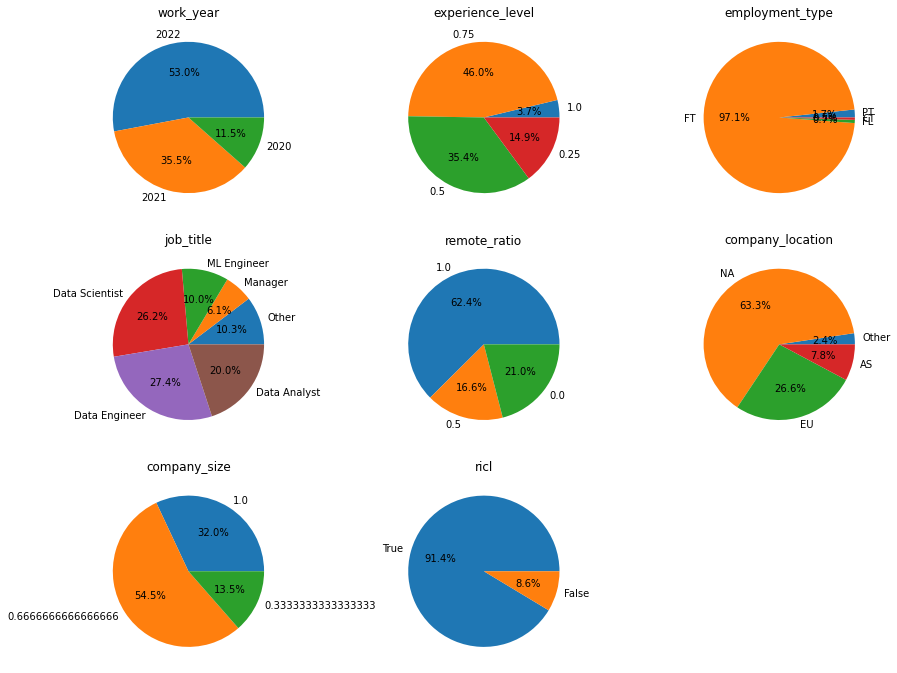

In [1522]:
lv_X_cols = salaries.columns.drop("salary_in_usd")
salaries[lv_X_cols].apply(pie_maker(lv_X_cols.size, 3))
plt.show()

#### Drop

Cols w/ Low Variance will not help w/ Modelling

In [1523]:
lv_cols = ["employment_type", "ricl"]

salaries.drop(columns=lv_cols, inplace=True)

displayCols(salaries)

,col
0,work_year
1,experience_level
2,job_title
3,salary_in_usd
4,remote_ratio
5,company_location
6,company_size


## Feature Selection

### Correlation Analysis

There are no strongly correlated cols

In [1524]:
pearson = salaries.corr()
spearman = salaries.corr("spearman")

display(pearson[pearson > .7])
display(spearman[spearman > .7])

,work_year,experience_level,salary_in_usd,remote_ratio,company_size
work_year,1.0,NaN,NaN,NaN,NaN
experience_level,NaN,1.0,NaN,NaN,NaN
salary_in_usd,NaN,NaN,1.0,NaN,NaN
remote_ratio,NaN,NaN,NaN,1.0,NaN
company_size,NaN,NaN,NaN,NaN,1.0


,work_year,experience_level,salary_in_usd,remote_ratio,company_size
work_year,1.0,NaN,NaN,NaN,NaN
experience_level,NaN,1.0,NaN,NaN,NaN
salary_in_usd,NaN,NaN,1.0,NaN,NaN
remote_ratio,NaN,NaN,NaN,1.0,NaN
company_size,NaN,NaN,NaN,NaN,1.0


# More Setup

## Imports

In [1525]:
# from sklearn

## Variables

In [1526]:
RANDOM_STATE = 1432

# Modelling

In [1527]:
dummies = pd.get_dummies(salaries)
X = dummies.drop(columns="salary_in_usd")
y = dummies["salary_in_usd"]

In [1528]:
X

,work_year,experience_level,remote_ratio,company_size,job_title_Data Analyst,job_title_Data Engineer,job_title_Data Scientist,job_title_ML Engineer,job_title_Manager,job_title_Other,company_location_AS,company_location_EU,company_location_NA,company_location_Other
0,2020,0.50,0.0,1.000000,0,0,1,0,0,0,0,1,0,0
2,2020,0.75,0.5,0.666667,0,1,0,0,0,0,0,1,0,0
3,2020,0.50,0.0,0.333333,1,0,0,0,0,0,0,0,1,0
4,2020,0.75,0.5,1.000000,0,0,0,1,0,0,0,0,1,0
5,2020,0.25,1.0,1.000000,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,0.75,1.0,0.666667,0,1,0,0,0,0,0,0,1,0
603,2022,0.75,1.0,0.666667,0,1,0,0,0,0,0,0,1,0
604,2022,0.75,0.0,0.666667,1,0,0,0,0,0,0,0,1,0
605,2022,0.75,1.0,0.666667,1,0,0,0,0,0,0,0,1,0


# Evaluation